In [3]:

from wqu.sm import MertonFourier

S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.4
lam = 1
mu = -0.2
delta = 0.1

merton = MertonFourier(S0, K, T, r, sigma, lam, mu, delta)
print(f"Merton Call Option Price (Lewis method): {merton.price():.6f}")

Merton Call Option Price (Lewis method): 19.947854


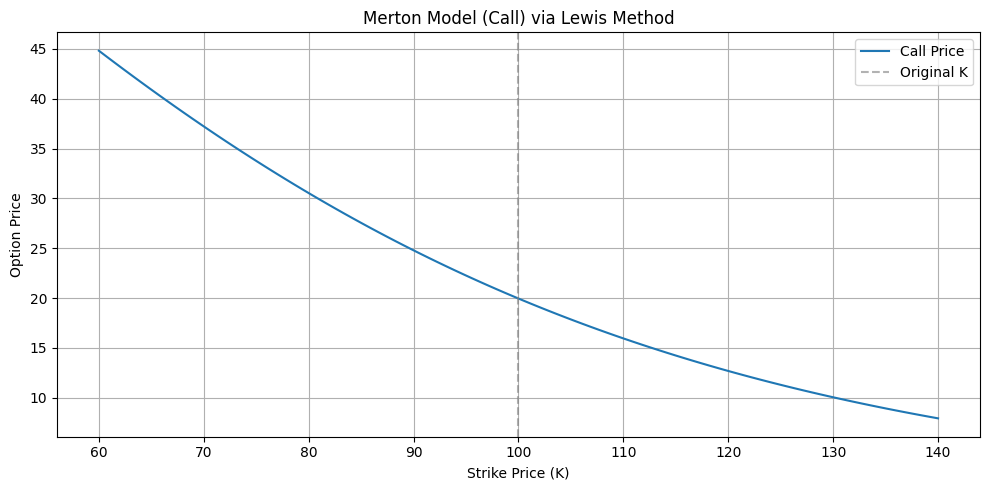

In [4]:
merton = MertonFourier(
    S0=100, K=100, T=1, r=0.05,
    sigma=0.4, lam=1, mu=-0.2, delta=0.1,
    option_type="call"
)

merton.plot(K_range=(60, 140))

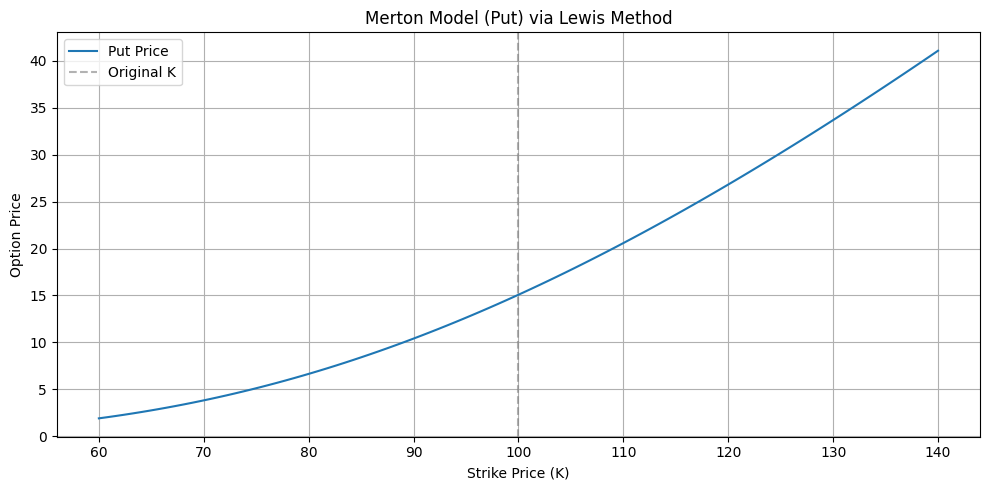

In [5]:
merton = MertonFourier(
    S0=100, K=100, T=1, r=0.05,
    sigma=0.4, lam=1, mu=-0.2, delta=0.1,
    option_type="put"
)

merton.plot(K_range=(60, 140))

In [1]:
from wqu.sm import MertonCalibrator
import pandas as pd

# Load your CSV
df = pd.read_csv("option_data_M2.csv")
S0 = 3225.93
df = df[(abs(df["Strike"] - S0) / S0) < 0.02].copy()
df["Date"] = pd.to_datetime(df["Date"])
df["Maturity"] = pd.to_datetime(df["Maturity"])
df["T"] = (df["Maturity"] - df["Date"]).dt.days / 365
df["r"] = 0.02
df = df.rename(columns={"Call": "MarketPrice"})

# Run calibration
calibrator = MertonCalibrator(S0=S0, options_df=df)
opt_params = calibrator.calibrate()
print("Optimal Parameters (σ, λ, μ, δ):", opt_params)

Brute force search...
   0 | [ 0.05  0.   -0.5   0.01] | MSE: 3200.1985 | Best: 500.0000
  25 | [0.05 0.   0.   0.01] | MSE: 3200.1985 | Best: 500.0000
  50 | [ 0.05  0.5  -0.1   0.01] | MSE: 1507.8682 | Best: 179.4044
  75 | [ 0.05  1.   -0.2   0.01] | MSE: 1217.0644 | Best: 135.1307
 100 | [ 0.05  1.5  -0.3   0.01] | MSE: 17214.8919 | Best: 135.1307
 125 | [ 0.25  0.   -0.4   0.01] | MSE: 4280.5063 | Best: 132.2890
 150 | [ 0.25  0.5  -0.5   0.01] | MSE: 19623.8849 | Best: 132.2890
 175 | [0.25 0.5  0.   0.01] | MSE: 4288.7093 | Best: 132.2890
 200 | [ 0.25  1.   -0.1   0.01] | MSE: 5886.4502 | Best: 132.2890
 225 | [ 0.25  1.5  -0.2   0.01] | MSE: 14504.2198 | Best: 132.2890
 250 | [ 0.45  0.   -0.3   0.01] | MSE: 36509.8909 | Best: 132.2890
 275 | [ 0.45  0.5  -0.4   0.01] | MSE: 52300.3190 | Best: 132.2890
 300 | [ 0.45  1.   -0.5   0.01] | MSE: 85956.3109 | Best: 132.2890
 325 | [0.45 1.   0.   0.01] | MSE: 36536.5113 | Best: 132.2890
 350 | [ 0.45  1.5  -0.1   0.01] | MSE: 40330

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import brute, fmin
from scipy.integrate import quad
import matplotlib.pyplot as plt

# === Step 1: Load and Prepare Data ===

csv_path = "option_data_M2.csv"
data = pd.read_csv(csv_path)

# Convert timestamps to datetime
data["Date"] = pd.to_datetime(data["Date"])
data["Maturity"] = pd.to_datetime(data["Maturity"])

# Set index level (spot price)
S0 = 3225.93
tol = 0.02

# Filter near-the-money options
options = data[(np.abs(data["Strike"] - S0) / S0) < tol].copy()

# Add time-to-maturity and risk-free rate
options["T"] = (options["Maturity"] - options["Date"]).dt.days / 365
options["r"] = 0.005  # ECB base rate as in textbook

# === Step 2: Merton (1976) Pricing Function ===

def merton_char_func(u, T, r, sigma, lam, mu, delta):
    """Merton (1976) characteristic function (Lewis form)"""
    omega = r - 0.5 * sigma**2 - lam * (np.exp(mu + 0.5 * delta**2) - 1)
    return np.exp(
        (1j * u * omega - 0.5 * sigma**2 * u**2 + lam * (np.exp(1j * u * mu - 0.5 * u**2 * delta**2) - 1)) * T
    )

def merton_integrand(u, S0, K, T, r, sigma, lam, mu, delta):
    """Integrand for Lewis-style pricing"""
    cf = merton_char_func(u - 0.5j, T, r, sigma, lam, mu, delta)
    value = (np.exp(1j * u * np.log(S0 / K)) * cf).real / (u**2 + 0.25)
    return value

def merton_call_value(S0, K, T, r, sigma, lam, mu, delta):
    """Merton call price via Fourier integral"""
    integral, _ = quad(lambda u: merton_integrand(u, S0, K, T, r, sigma, lam, mu, delta), 0, 50, limit=250)
    return max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * integral)

# === Step 3: Error Function for Calibration ===

i = 0
min_RMSE = 100

def merton_error_function(p):
    global i, min_RMSE
    sigma, lam, mu, delta = p
    if sigma < 0 or lam < 0 or delta < 0:
        return 500.0
    se = []
    for _, opt in options.iterrows():
        model_price = merton_call_value(S0, opt["Strike"], opt["T"], opt["r"], sigma, lam, mu, delta)
        se.append((model_price - opt["Call"])**2)
    rmse = np.sqrt(np.mean(se))
    min_RMSE = min(min_RMSE, rmse)
    if i % 50 == 0:
        print(f"{i:4d} | {np.array(p)} | {rmse:7.3f} | {min_RMSE:7.3f}")
    i += 1
    return rmse

# === Step 4: Calibration Routine ===

def merton_calibration():
    p0 = brute(
        merton_error_function,
        ranges=(
            (0.075, 0.201, 0.025),   # sigma
            (0.10, 0.401, 0.1),      # lambda
            (-0.5, 0.01, 0.1),       # mu
            (0.10, 0.301, 0.1),      # delta
        ),
        finish=None
    )
    opt = fmin(
        merton_error_function,
        p0,
        xtol=1e-4,
        ftol=1e-4,
        maxiter=550,
        maxfun=1050
    )
    return opt

# Run calibration
opt_params = merton_calibration()
print("Optimal Parameters:", opt_params)

   0 | [ 0.075  0.1   -0.5    0.1  ] |  31.540 |  31.540
  50 | [ 0.075  0.3   -0.1    0.3  ] |  22.852 |  11.298
 100 | [ 0.1  0.2 -0.2  0.2] |  19.922 |   8.654
 150 | [ 0.125  0.1   -0.3    0.1  ] |  10.704 |   5.571
 200 | [ 0.125  0.4   -0.5    0.3  ] |  55.500 |   4.662
 250 | [0.15 0.2  0.   0.2 ] |   6.619 |   3.586
 300 | [ 0.175  0.1   -0.1    0.1  ] |  14.171 |   3.586
 350 | [ 0.175  0.4   -0.3    0.3  ] |  54.376 |   3.586
 400 | [ 0.2  0.3 -0.4  0.2] |  63.380 |   3.586
 450 | [ 0.14702168  0.19533978 -0.10189428  0.10218084] |   3.495 |   3.428
 500 | [ 0.14987758  0.11503181 -0.14398098  0.09850597] |   3.401 |   3.401
 550 | [ 0.15597729  0.01124105 -0.20255149  0.07785796] |   3.359 |   3.359
 600 | [ 0.15617567  0.00947711 -0.20364524  0.07721602] |   3.358 |   3.358
Optimization terminated successfully.
         Current function value: 3.358419
         Iterations: 107
         Function evaluations: 183
Optimal Parameters: [ 0.15619381  0.009201   -0.20380034  0.077

In [3]:
def plot_merton_fit(opt_params, options):
    sigma, lam, mu, delta = opt_params
    options = options.copy()
    options["Model"] = [
        merton_call_value(S0, row["Strike"], row["T"], row["r"], sigma, lam, mu, delta)
        for _, row in options.iterrows()
    ]
    for mat in sorted(set(options["Maturity"])):
        subset = options[options["Maturity"] == mat].set_index("Strike")
        subset[["Call", "Model"]].plot(title=f"Maturity: {mat.date()}", style=["b-", "ro"])
        plt.ylabel("Option Price")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

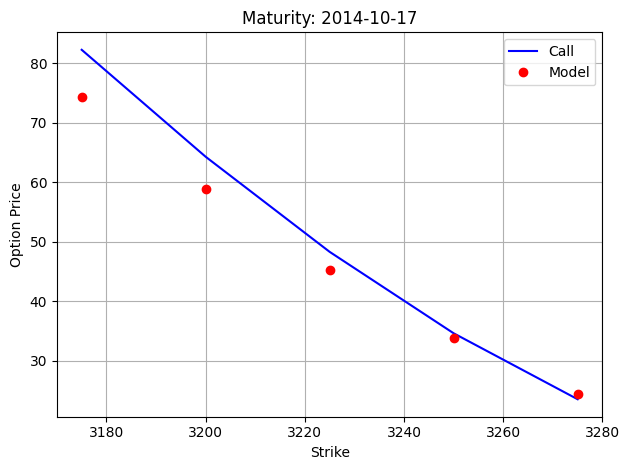

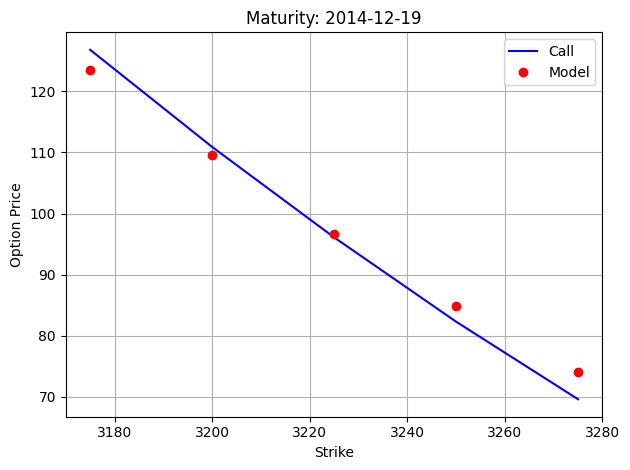

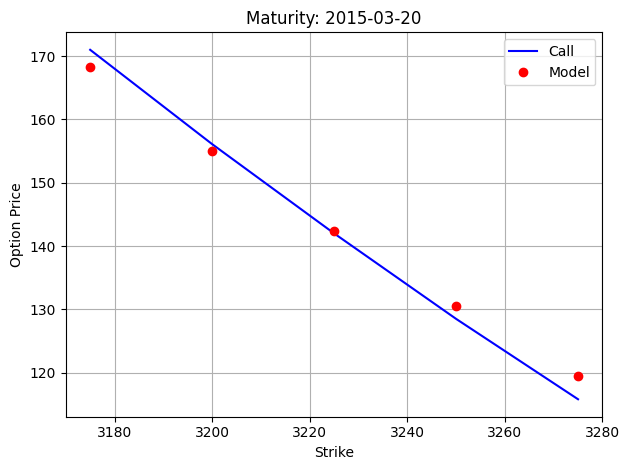

In [4]:
plot_merton_fit(opt_params, options)

In [1]:
import pandas as pd
from wqu.sm import MertonCalibrator

# Load the dataset
df = pd.read_csv("option_data_M2.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["Maturity"] = pd.to_datetime(df["Maturity"])
df["T"] = (df["Maturity"] - df["Date"]).dt.days / 365
df["r"] = 0.005

# Set tolerance and filter ATM options
S0 = 3225.93
tol = 0.02
options = df[(abs(df["Strike"] - S0) / S0) < tol].copy()

# Run calibration
calibrator = MertonCalibrator(S0, options)
opt_params = calibrator.calibrate()
print("Optimal Parameters:", opt_params)

   0 | [ 0.075  0.1   -0.5    0.1  ] |  31.540 |  31.540
  50 | [ 0.075  0.3   -0.1    0.3  ] |  22.852 |  11.298
 100 | [ 0.1  0.2 -0.2  0.2] |  19.922 |   8.654
 150 | [ 0.125  0.1   -0.3    0.1  ] |  10.704 |   5.571
 200 | [ 0.125  0.4   -0.5    0.3  ] |  55.500 |   4.662
 250 | [0.15 0.2  0.   0.2 ] |   6.619 |   3.586
 300 | [ 0.175  0.1   -0.1    0.1  ] |  14.171 |   3.586
 350 | [ 0.175  0.4   -0.3    0.3  ] |  54.376 |   3.586
 400 | [ 0.2  0.3 -0.4  0.2] |  63.380 |   3.586
 450 | [ 0.14702168  0.19533978 -0.10189428  0.10218084] |   3.495 |   3.428
 500 | [ 0.14987758  0.11503181 -0.14398098  0.09850597] |   3.401 |   3.401
 550 | [ 0.15597729  0.01124105 -0.20255149  0.07785796] |   3.359 |   3.359
 600 | [ 0.15617567  0.00947711 -0.20364524  0.07721602] |   3.358 |   3.358
Optimization terminated successfully.
         Current function value: 3.358419
         Iterations: 107
         Function evaluations: 183
Optimal Parameters: [ 0.15619381  0.009201   -0.20380034  0.077

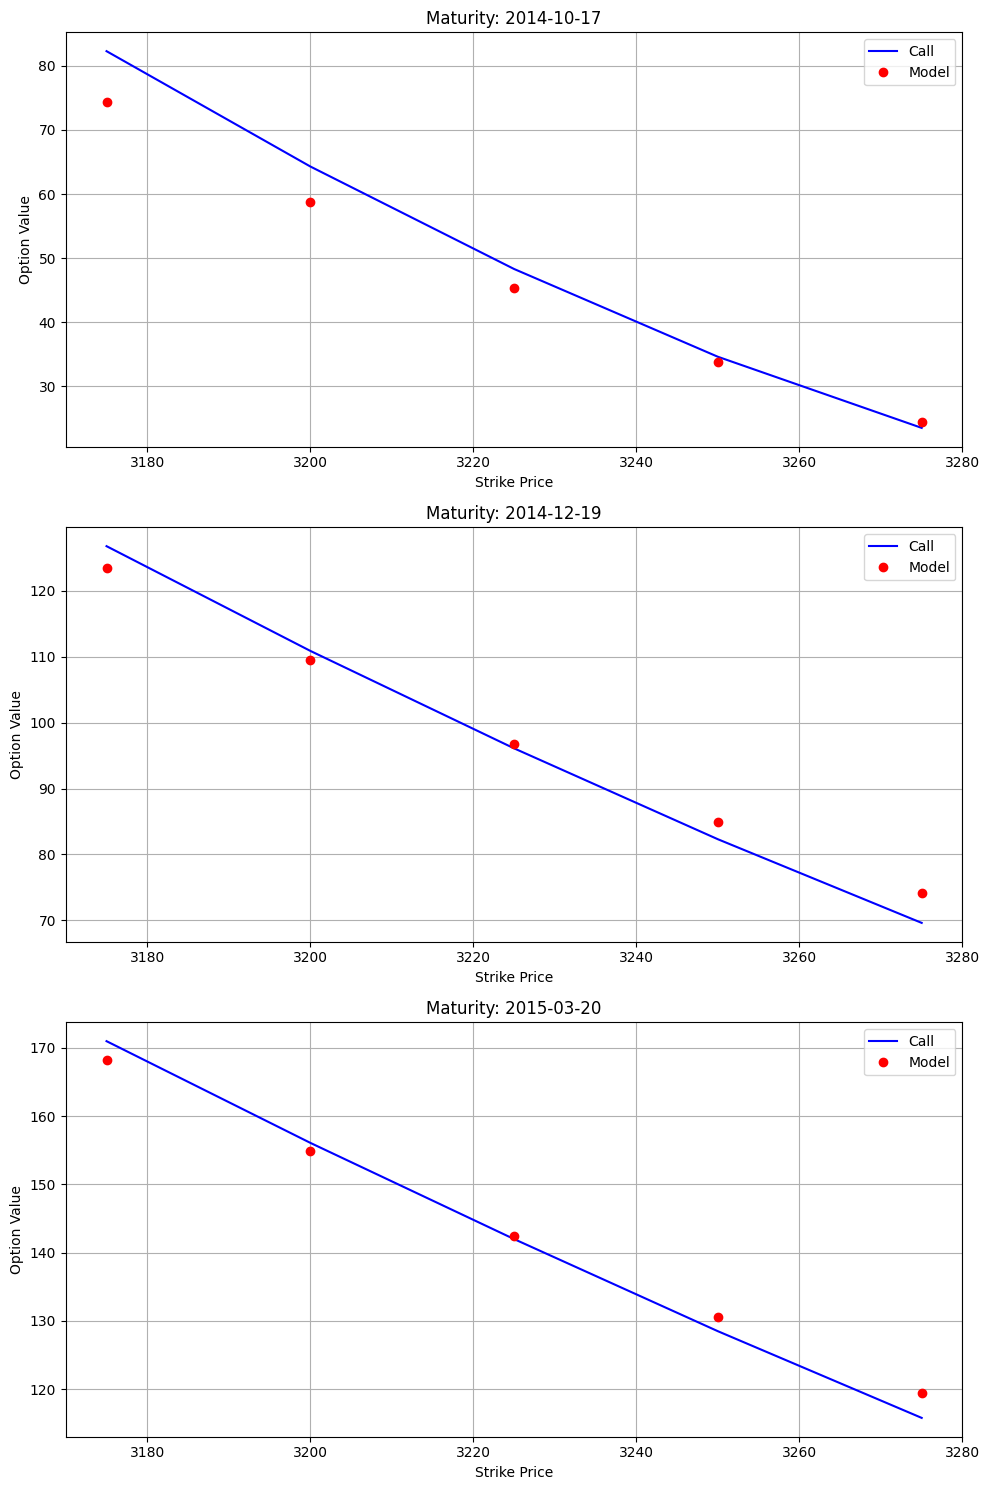

In [2]:
# Plot fit
calibrator.plot(opt_params)